<a href="https://colab.research.google.com/github/riya-chougule/Image_segmentation_for_self_driving_cars_using_deep_learning_techniques/blob/main/Trial_and_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [2]:
from pathlib import Path
from fastai.vision import *
import wandb
from wandb.fastai import WandbCallback
from functools import partialmethod

In [ ]:
wandb.init(project="semantic-segmentation")

In [4]:
config = wandb.config           # for shortening
config.framework = "fast.ai"    
config.img_size = (360, 640)    # dimensions of resized image - can be 1 dim or tuple
config.batch_size = 4           # Batch size during training
config.epochs = 20              # Number of epochs for training
encoder = models.resnet18       
config.encoder = encoder.__name__
config.pretrained = True       
config.weight_decay = 1e-4      # weight decay applied on layers
config.bn_weight_decay = False  
config.one_cycle = True        
config.learning_rate = 3e-3     # learning rate
save_model = True

In [5]:
config.training_stages = 2
path_data = Path('../data/bdd100k/seg')
path_lbl = path_data / 'labels'
path_img = path_data / 'images'

path_data = Path('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg')
path_lbl = path_data / 'labels'
path_img = path_data / 'images'

get_y_fn = lambda x: path_lbl / x.parts[-2] / f'{x.stem}_train_id.png'

In [6]:
segmentation_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
void_code = 19

In [7]:
src = (SegmentationItemList.from_folder(path_img).use_partial_data(0.01)
       .split_by_folder(train='train', valid='val')
       .label_from_func(get_y_fn, classes=segmentation_classes))
data = (src.transform(get_transforms(), size=config.img_size, tfm_y=True)
        .databunch(bs=config.batch_size)
        .normalize(imagenet_stats))

In [8]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()
    
learn = unet_learner(
data,arch=encoder,
pretrained=config.pretrained,
metrics=acc,
wd=config.weight_decay,
bn_wd=config.bn_weight_decay,
callback_fns=partial(WandbCallback, save_model=save_model, monitor='acc', input_type='images'))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [9]:
if config.one_cycle:
    learn.fit_one_cycle(
        config.epochs // 2,
        max_lr=slice(config.learning_rate))
    learn.unfreeze()
    learn.fit_one_cycle(
        config.epochs // 2,
        max_lr=slice(config.learning_rate / 100,
                     config.learning_rate / 10))
else:
    learn.fit(
        config.epochs,
        lr=slice(config.learning_rate))

epoch,train_loss,valid_loss,acc,time
0,2.173371,1.798965,0.401049,00:32
1,2.080833,1.803222,0.509240,00:12
2,1.963311,1.610194,0.502058,00:12
3,1.858761,1.606590,0.509429,00:12
4,1.807084,1.740840,0.379153,00:12
5,1.808891,1.592705,0.502687,00:12
6,1.748507,1.355192,0.612529,00:12
7,1.649334,1.203429,0.685874,00:12
8,1.538610,1.072047,0.729134,00:12
9,1.422076,1.078835,0.722991,00:12


Better model found at epoch 0 with acc value: 0.4010494649410248.
Better model found at epoch 1 with acc value: 0.5092397332191467.
Better model found at epoch 3 with acc value: 0.509429395198822.
Better model found at epoch 6 with acc value: 0.6125292778015137.
Better model found at epoch 7 with acc value: 0.6858735680580139.
Better model found at epoch 8 with acc value: 0.7291343808174133.
Loaded best saved model from /content/wandb/run-20210605_182558-33poaf2p/files/bestmodel.pth


epoch,train_loss,valid_loss,acc,time
0,1.184307,1.024752,0.748948,00:13
1,1.133369,1.002983,0.721358,00:13
2,1.088696,0.871368,0.785878,00:13
3,1.031096,0.820664,0.811339,00:13
4,0.989267,0.826990,0.819607,00:13
5,0.937677,0.728288,0.831633,00:13
6,0.875900,0.692180,0.816084,00:13
7,0.815290,0.640456,0.837388,00:13
8,0.765883,0.634770,0.837748,00:13
9,0.728490,0.636506,0.837349,00:13


Better model found at epoch 0 with acc value: 0.7489476203918457.
Better model found at epoch 2 with acc value: 0.7858781814575195.
Better model found at epoch 3 with acc value: 0.8113386034965515.
Better model found at epoch 4 with acc value: 0.8196074962615967.
Better model found at epoch 5 with acc value: 0.8316332697868347.
Better model found at epoch 7 with acc value: 0.837388277053833.
Better model found at epoch 8 with acc value: 0.8377482295036316.
Loaded best saved model from /content/wandb/run-20210605_182558-33poaf2p/files/bestmodel.pth


In [10]:
learn.export()
path = Path('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images')
path.ls()

[PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/test'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/train'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/val'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/models'),
 PosixPath('/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/export.pkl')]

In [11]:
path
learn_inf = load_learner(path)

In [12]:
learn_inf = load_learner(path)


In [13]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [14]:
from PIL import Image as PImage
from fastai.vision import *
frame=cv2.imread("/content/drive/MyDrive/Kaggle/bdd100k_seg/bdd100k/seg/images/test/ae7bcd76-00000000.jpg")
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
pil_im = PImage.fromarray(frame) 
x = pil2tensor(pil_im ,np.float32)
preds_num = learn_inf.predict(Image(x))[2].numpy()

In [15]:
len(preds_num)

20

In [16]:
preds_num

array([[[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00],
        ...,
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         4.592840e-40],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         1.450344e-42],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00, 0.000000e+00,
         4.203895e-45],
        [0.000000e+00, 0.000000e+00

In [17]:
preds_num.shape

(20, 360, 640)

In [18]:
pred_argx=np.argmax(preds_num,axis=0)

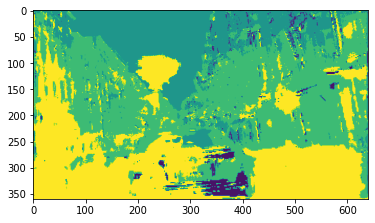

In [21]:
plt.imshow(pred_argx)